### This is an notebook containing example codes for forming Relaxed Decision Region. 
- For data preprocessing and fine-tuning the model, we refer the following code. 
    - https://developer.huaweicloud.com/develop/aigallery/notebook/detail?id=8e92ea6c-2f4a-4cff-a89f-bf2905bb7ac0


In [1]:
import numpy as np
import torch 
from time import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from models.utilities.mDataset import mDataset
from models.vgg19 import *
from models.rdr import *
from models.metrics import *
from models.configurations import *

/home/dahee/anaconda3/envs/masactrl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## 1) Load Data

In [2]:
# train_data = mDataset('/data/mini-imagenet/mini-imagenet-train.pt')
# test_data = mDataset('/data/mini-imagenet/mini-imagenet-test.pt')

train_data = mDataset('/data1/dahee/data/mini-imagenet/mini-imagenet-train.pt')
test_data = mDataset('/data1/dahee/data/mini-imagenet/mini-imagenet-test.pt')

## 2) Load Model

In [3]:
model = VGG19(64, num_blocks=5, feature_size=2, classifier_dim=[1024, 1024]).cuda()
model.load_pretrained()
# model.loadModel('/models/VGG19_imagenet_b5_1024.pth')
model.loadModel('/data1/dahee/models/VGG19_imagenet_b5_1024.pth')

/home/dahee/anaconda3/envs/masactrl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dahee/anaconda3/envs/masactrl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from /data1/dahee/models/VGG19_imagenet_b5_1024.pth


## 3) Update Data

In [4]:
target_layer = 27 ## 36 = before linear classifier // 27 = 4th after vgg conv block

In [5]:
train_data.updateLabels(model)
train_data.updateFeatures(model, target_layer)      

In [6]:
data_len = len(train_data)
features = train_data.features
features = features.view([data_len,-1])

### 3-1) Label Information

In [7]:
f = open("./models/MiniImageNet_cls_decoded.txt", 'r')

class_dict = dict()

for i in range(64):
    idx, class_name = f.readline().split()
    class_dict[int(idx)] = class_name
    
f.close()

----
----

## Computing Configurations

In [8]:
_, configs = getconfigs(train_data,model,tar_layer=27)

100%|██████████| 480/480 [00:13<00:00, 34.30it/s]


## Choosing the target instance

In [9]:
classes = torch.unique(train_data[:][1])
classes = np.array(classes)

In [10]:
rand_target = np.random.choice(data_len,1)[0]

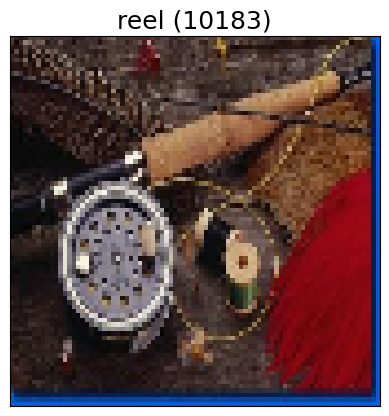

reel


In [11]:
tar_label = train_data[:][1][rand_target].numpy()
tar_label_true = train_data.true_labels[rand_target].numpy()
plt.title('{} ({})'.format(class_dict[int(tar_label)],rand_target), fontsize=18)
plt.imshow(train_data[:][0][rand_target].permute(1,2,0))
plt.xticks([])
plt.yticks([])
plt.show()
print(class_dict[int(tar_label_true)])

## Computing configuration distance

In [12]:
config_values = config_dist(configs, rand_target,np.arange(len(features)), n_jobs=4)
config_similars = np.argsort(config_values)

# Forming Relaxed Decision Region

Pred:  reel
True:  reel
5 decision boundaries are used for constructing relaxed decision region.
The number of samples included in the Relaxed Decision Region: 86


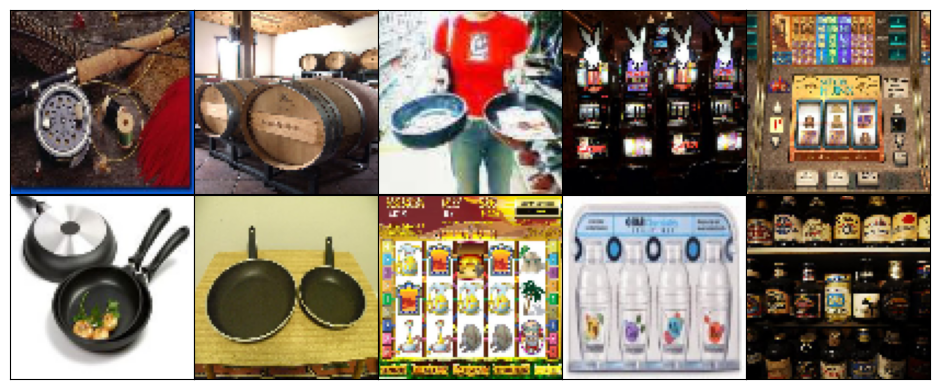

In [13]:
from models.rdr import RDR, visualize

tar_label = int(train_data[:][1][rand_target].numpy())
org_class = int(train_data.true_labels[rand_target])

print('Pred: ', class_dict[tar_label])
print('True: ', class_dict[org_class])

rdr = RDR(config_similars, configs)
rdr_samples, rdr_neurons, rdr_states = rdr.selection(k=8, t=5)

visualize(rdr_samples, train_data[:][0])